# Task 2

## Import Libraries

In [1]:
import sys
sys.path.append('../src')

import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from tqdm import tqdm
from datetime import datetime

from environment_gym import TrafficEnvironment
from task2_environment import CustomTrafficEnvironment
from task2_agents import RuleBasedAgent, TemporalDifference
from visualization import extract_timesteps_from_json, create_visualization_from_cached_data

seed = 2024
training_seed = 42

c:\Users\danie\OneDrive - Singapore Management University\SMU Singapore\Academics\Aug 2024\CS609_ReinforcementLearning\Project\LaneSwitchRL-Simulation\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Rule-Based Agent

### Fastest Adjacent Lane

100%|██████████| 500/500 [00:33<00:00, 15.12it/s]


Truncated episodes: 139
Average cumulative rewards for Fastest Adjacent Lane strategy: -492
Average timesteps to termination for Fastest Adjacent Lane strategy: 358


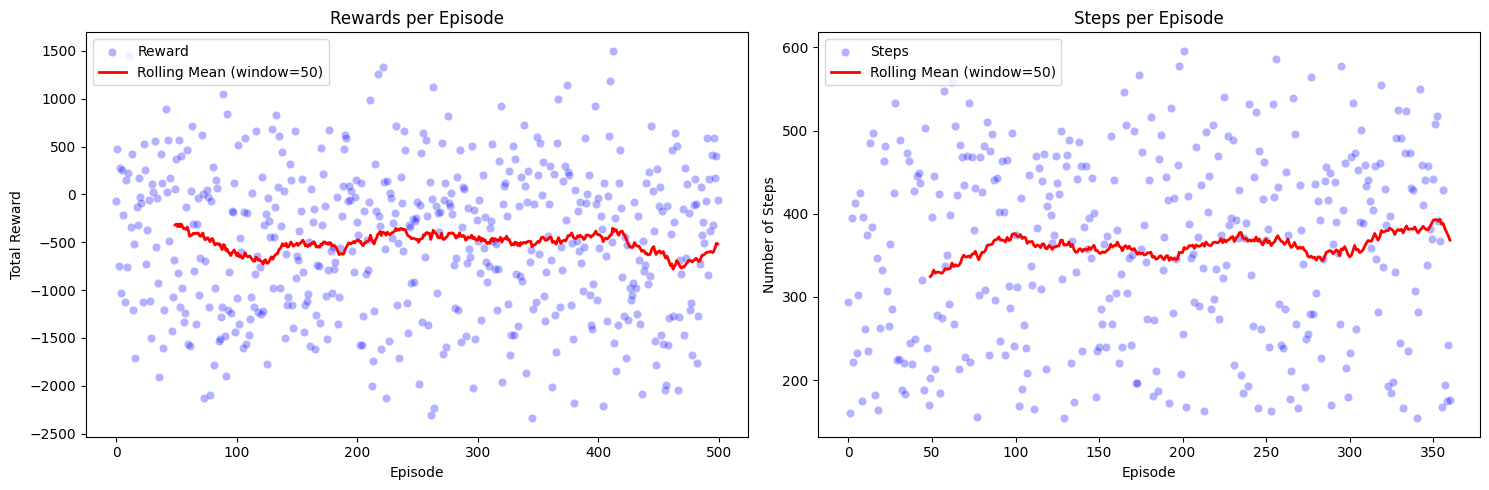

In [2]:
# Create the environment
env = CustomTrafficEnvironment(max_time_steps=10000, logging_enabled=False, seed=seed)
# Evaluate each strategy
rewards_dict = {}
timesteps_dict = {}

agent = RuleBasedAgent(env=env, strategy='fastest_adjacent')
# episode_rewards, checkpoint_rewards, timesteps_to_termination = evaluate_agent(agent, env)
all_episode_rewards, all_timesteps, fast_log_file = agent.evaluate_agent(num_episodes=500, output_file=f'./logs/task2/fast_lane/fast_lane_test_log_{datetime.now().strftime('%Y%m%d_%H%M%S')}.json')
rewards_dict['Fastest Adjacent Lane Agent'] = all_episode_rewards
timesteps_dict['Fastest Adjacent Lane Agent'] = all_timesteps
# env.logger.info("\n"*5)

print(f'Average cumulative rewards for Fastest Adjacent Lane strategy: {round(np.mean(rewards_dict['Fastest Adjacent Lane Agent']))}')
print(f'Average timesteps to termination for Fastest Adjacent Lane strategy: {round(np.mean(timesteps_dict["Fastest Adjacent Lane Agent"]))}')
agent.plot_metrics(all_episode_rewards, all_timesteps, window_size=50)
plt.show()

In [3]:
json_path = fast_log_file

extract_timesteps_from_json(json_path)
gif_filename = os.path.basename(json_path).replace('.json', '.gif')

gif_filepath = f'./gifs/task2/{gif_filename}'

create_visualization_from_cached_data(gif_filename=gif_filepath, step_interval=1)

Timesteps data from the first line successfully cached, containing 294 timesteps
GIF saved at ./gifs/task2/fast_lane_test_log_20241107_164219.gif


### Same Lane

100%|██████████| 500/500 [00:42<00:00, 11.66it/s]


Truncated episodes: 181
Average cumulative rewards for Same Lane Agent 1: -1719
Average timesteps to termination for Same Lane Agent 1: 470




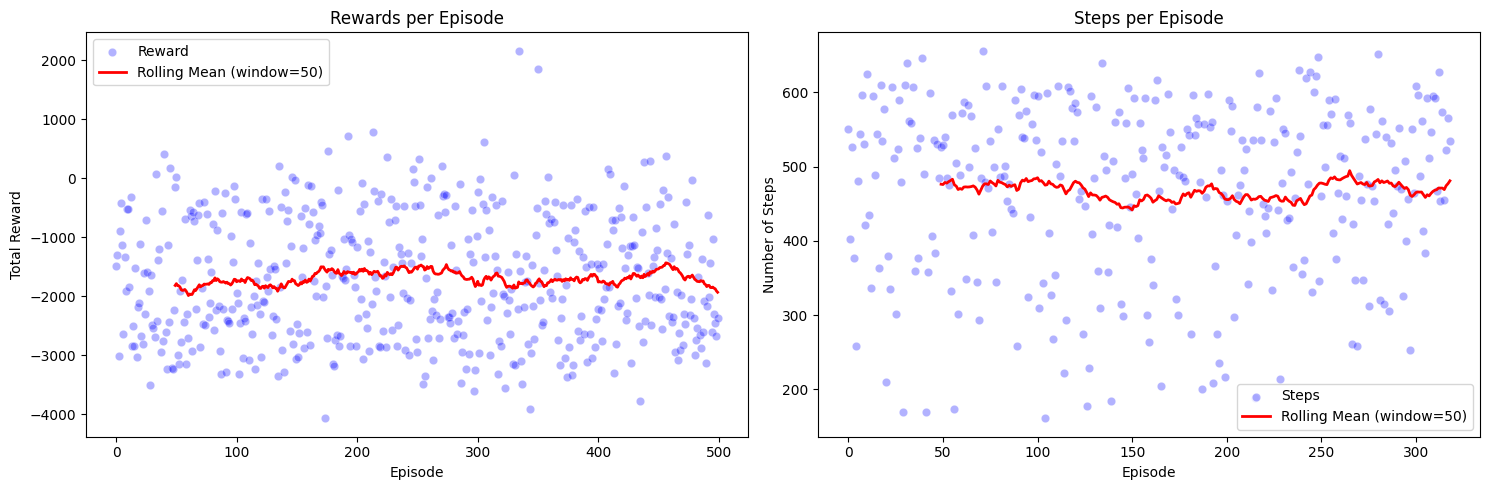

100%|██████████| 500/500 [01:07<00:00,  7.39it/s]


Truncated episodes: 184
Average cumulative rewards for Same Lane Agent 2: -2342
Average timesteps to termination for Same Lane Agent 2: 469




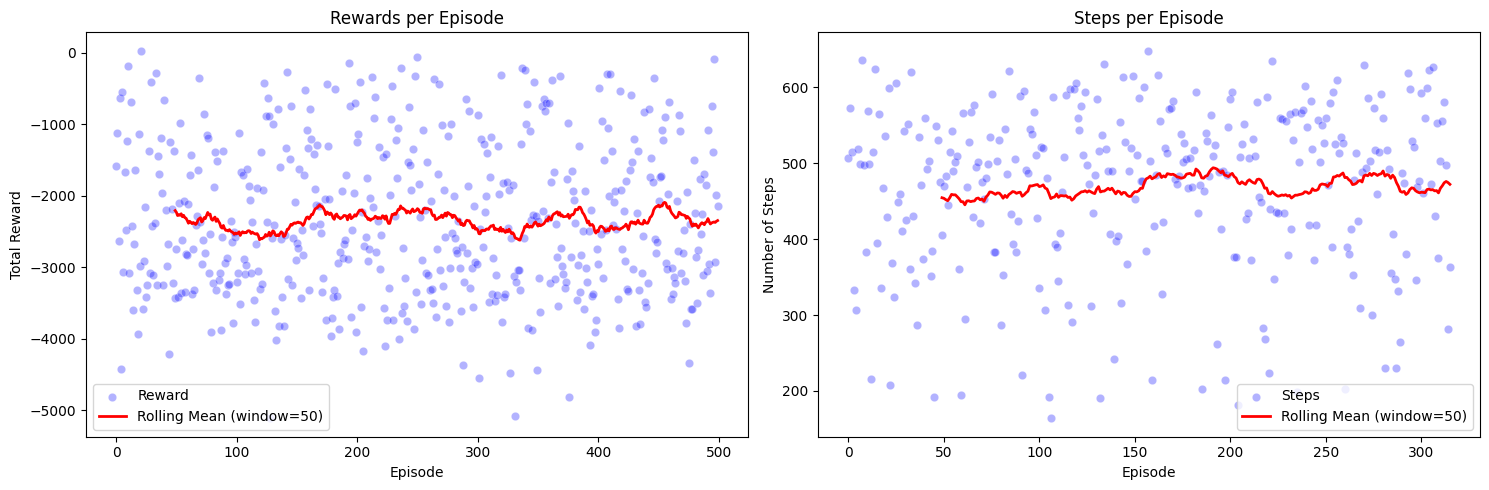

100%|██████████| 500/500 [01:10<00:00,  7.10it/s]


Truncated episodes: 177
Average cumulative rewards for Same Lane Agent 3: -2117
Average timesteps to termination for Same Lane Agent 3: 455




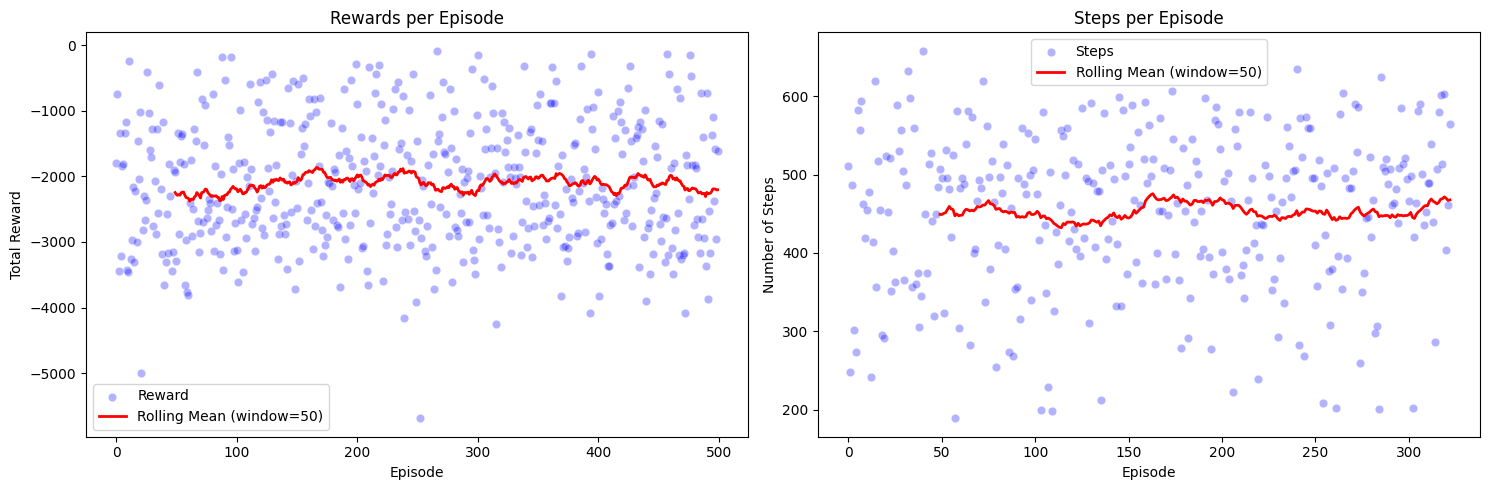

100%|██████████| 500/500 [00:44<00:00, 11.15it/s]


Truncated episodes: 180
Average cumulative rewards for Same Lane Agent 4: -2442
Average timesteps to termination for Same Lane Agent 4: 473




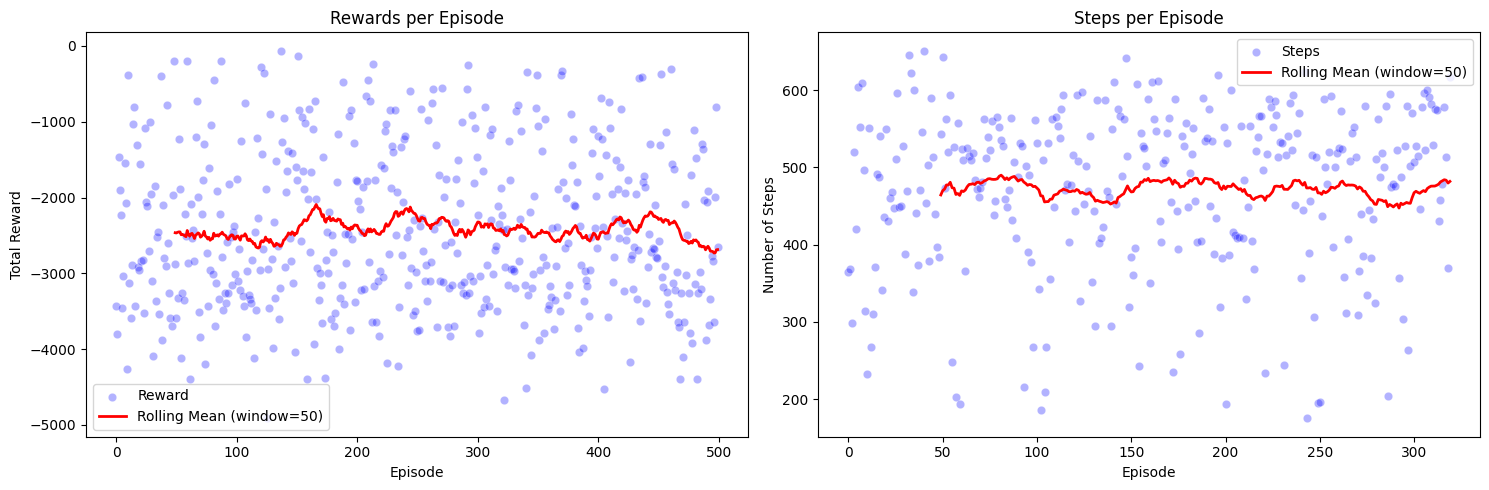

100%|██████████| 500/500 [01:08<00:00,  7.31it/s]


Truncated episodes: 183
Average cumulative rewards for Same Lane Agent 5: -1802
Average timesteps to termination for Same Lane Agent 5: 481




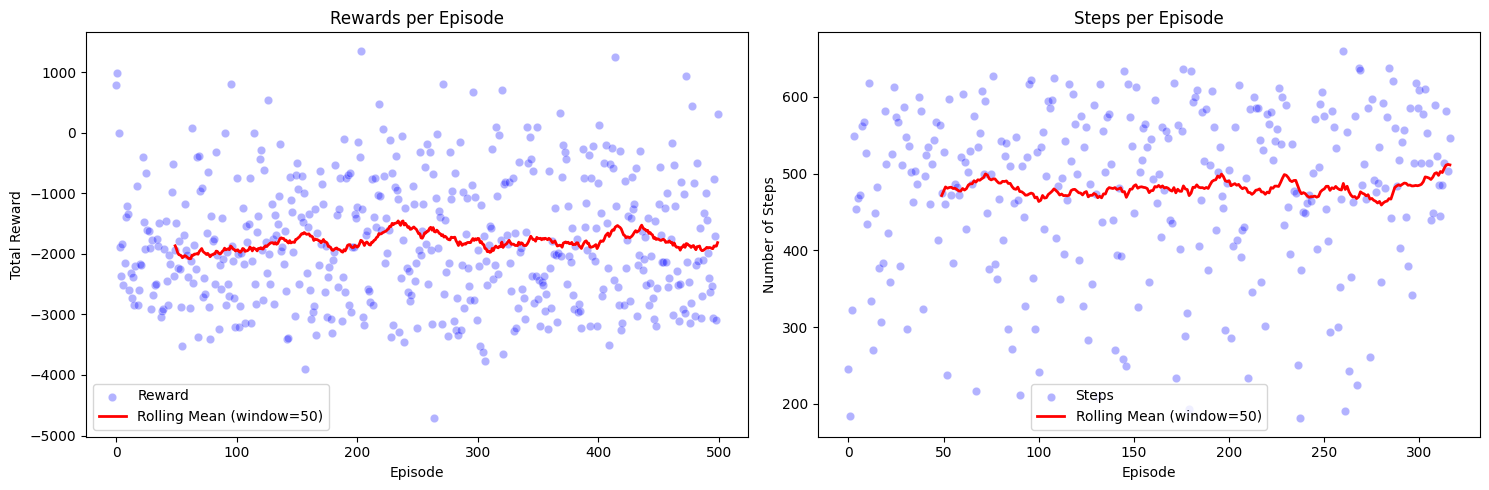

In [4]:
# Create the environment
env = CustomTrafficEnvironment(max_time_steps=10000, logging_enabled=False, seed=seed)
rewards_dict = {}
timesteps_dict = {}
log_files = []
for i in range(5):
    agent = RuleBasedAgent(env=env, strategy='stay')
    all_episode_rewards, all_timesteps, log_file = agent.evaluate_agent(num_episodes=500, starting_lane=i+1, output_file=f'./logs/task2/same_lane/rule_lane{i+1}_test_log_{datetime.now().strftime('%Y%m%d_%H%M%S')}.json')
    log_files.append(log_file)
    rewards_dict[f'Same Lane Agent {i+1}'] = all_episode_rewards
    timesteps_dict[f'Same Lane Agent {i+1}'] = all_timesteps
    
    print(f'Average cumulative rewards for Same Lane Agent {i+1}: {round(np.mean(all_episode_rewards))}')
    print(f'Average timesteps to termination for Same Lane Agent {i+1}: {round(np.mean(all_timesteps))}')
    print('\n')
    agent.plot_metrics(all_episode_rewards, all_timesteps, window_size=50)
    plt.show()

In [5]:
for i in range(1):
    json_path = log_files[i]

    extract_timesteps_from_json(json_path)
    gif_filename = os.path.basename(json_path).replace('.json', '.gif')

    gif_filepath = f'./gifs/task2/{gif_filename}'

    create_visualization_from_cached_data(gif_filename=gif_filepath, step_interval=1)

Timesteps data from the first line successfully cached, containing 288 timesteps
GIF saved at ./gifs/task2/rule_lane1_test_log_20241107_164346.gif


## Value-based Agent

### Training

To beat: 139 accidents, 358 timesteps, Reward: -492

{'alpha': 0.005570186745951954, 'gamma': 0.5512247590348421, 'epsilon_min': 0.061269100902687786}  

100%|██████████| 1000/1000 [01:10<00:00, 14.09it/s]


Early Termination Count: 327
Sum of total rewards = -1030761.3000000002
Average total reward per episode = -1030.7613000000001
Average steps per episode = 385.62852897474


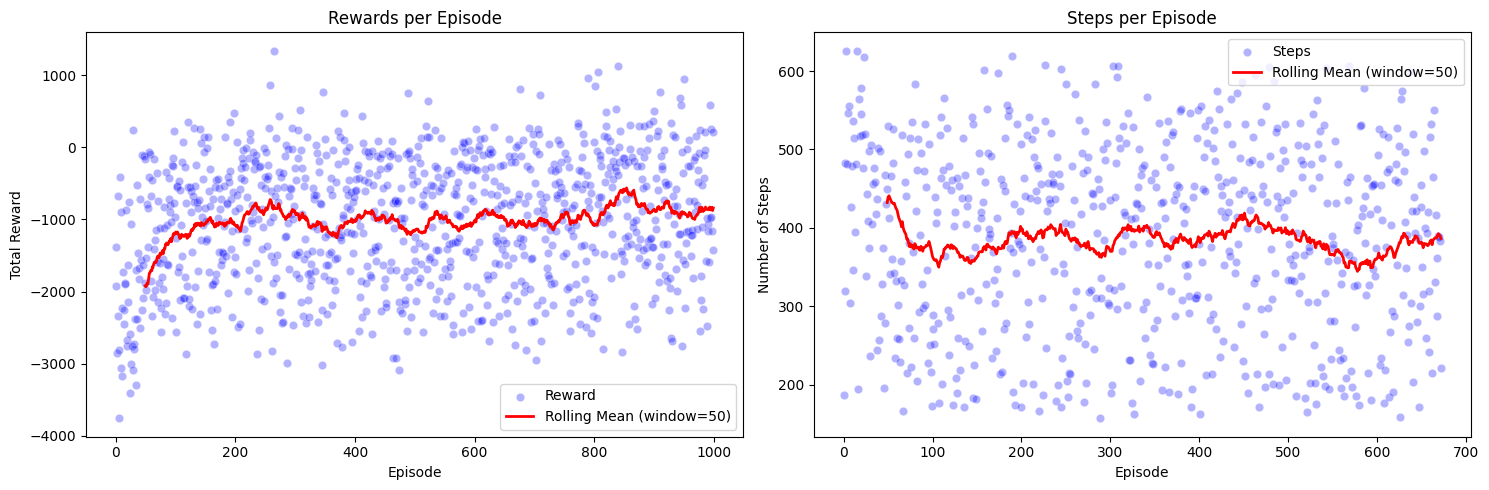

In [40]:
# Create the environment
env = CustomTrafficEnvironment(max_time_steps=10000, logging_enabled=False, seed=training_seed)

td_lambda = TemporalDifference(env, oiv = 0.1, alpha=9e-3, epsilon=1.0, lambd=0, gamma=0.55, epsilon_decay=0.9999, epsilon_min=0.06)
# td_lambda = TemporalDifference(env, oiv = 0.1, alpha=5.5e-5, epsilon=1.0, lambd=0, gamma=0.14, epsilon_decay=0.9999, epsilon_min=0.017)
total_reward_list, total_steps_list = td_lambda.train(num_episodes = 1000, on_policy = False, save_model = False)
total_rew = sum(total_reward_list)
avg_rew = np.mean(total_reward_list)
avg_steps = np.mean(total_steps_list)

print(f'Sum of total rewards = {total_rew}')
print(f'Average total reward per episode = {avg_rew}')
print(f'Average steps per episode = {avg_steps}')

# plot training metrics
td_lambda.plot_metrics(total_reward_list, total_steps_list, window_size=50)
plt.show()

In [15]:
# Convert the list to a pandas Series
rewards_series = pd.Series(total_reward_list)

# Calculate the rolling average with a window size of 50
rolling_avg = rewards_series.rolling(window=50).mean()

# Find the index where the rolling average is highest
max_rolling_avg_index = rolling_avg.idxmax()

print("Index with the highest rolling average:", max_rolling_avg_index)
print("Highest rolling average:", rolling_avg[max_rolling_avg_index])

Index with the highest rolling average: 1373
Highest rolling average: -615.4800000000001


### Analysis

In [13]:
print(f'Filled State Space: {len(td_lambda.Q)}')
td_lambda.Q.items()

Filled State Space: 4401


dict_items([((5, 0, 5, 0), array([-0.07861442,  3.64430111,  0.21337632])), ((5, 5, 4, 0), array([0.10370176, 0.85865552, 0.10405185])), ((4, 5, 4, 0), array([0.28581441, 0.1       , 0.10293596])), ((4, 4, 4, 1), array([0.1028304 , 0.46245855, 0.1       ])), ((4, 4, 5, 0), array([0.11164283, 0.10896355, 0.58506957])), ((4, 4, 6, 1), array([0.10364166, 0.1       , 0.21316528])), ((6, 4, 0, 1), array([0.14788172, 0.1       , 0.09525905])), ((6, 5, 0, 1), array([0.10572176, 0.37733978, 0.1       ])), ((4, 5, 6, 2), array([0.10659462, 0.1       , 0.15038684])), ((4, 5, 5, 2), array([0.10235776, 0.35320412, 0.09549315])), ((4, 5, 5, 1), array([0.16477053, 0.10490679, 0.1       ])), ((4, 6, 4, 2), array([0.15579855, 0.1       , 0.1       ])), ((6, 0, 4, 2), array([0.07948634, 0.95643203, 0.10457836])), ((5, 0, 4, 2), array([0.06540997, 0.94848691, 0.09952755])), ((5, 0, 5, 2), array([0.05847697, 1.44562647, 0.11080095])), ((6, 0, 5, 2), array([0.07055205, 1.45321335, 0.10836108])), ((6, 6, 3

Action Distribution:
Left:  1022 (30.3%)
Stay:  1581 (46.9%)
Right:  771 (22.9%)


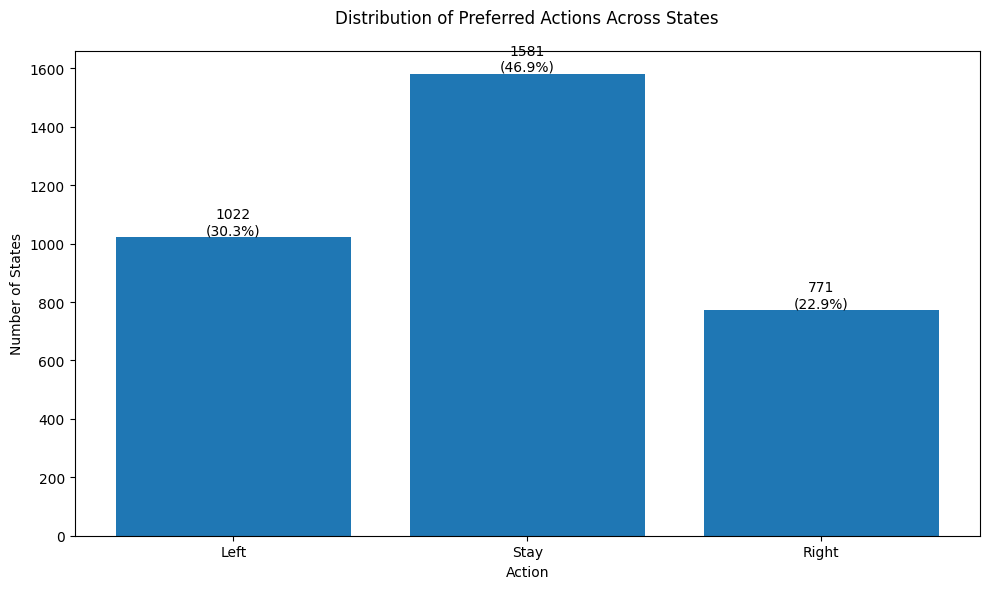

(1022, 1581, 771, 30.29045643153527, 46.8583283935981, 22.851215174866628)

In [22]:
td_lambda.analyze_model_actions()

State Space Size = 10 x 10 x 10 (Clearance Rates) x 5 (Risk Factor) x 3 (Actions) = 15,000

In [8]:
q_df = td_lambda.q_table_to_dataframe()
q_df.head()

,Current Lane Rate,Left Lane Rate,Right Lane Rate,Risk Factor,Left,Stay,Right
0,6,5,5,0,-0.183164,0.073715,-0.070661
1,5,0,5,0,-1.471224,-1.410443,-1.182697
2,2,0,5,5,-0.055873,-0.178649,1.273321
3,5,3,5,5,-0.597426,-0.541671,-0.528547
4,3,0,5,5,0.100000,-0.001165,0.689591


In [9]:
lanes = ['Current', 'Left', 'Right']
for fast_lane in lanes:
    other_lanes = lanes.copy()
    other_lanes.remove(fast_lane)
    total = q_df.loc[((q_df[f'{fast_lane} Lane Rate'] > q_df[f'{other_lanes[0]} Lane Rate']) & (q_df[f'{fast_lane} Lane Rate'] > q_df[f'{other_lanes[1]} Lane Rate'])) & (q_df['Risk Factor'] < 5)].shape[0]
    rate = q_df.loc[((q_df[f'{fast_lane} Lane Rate'] > q_df[f'{other_lanes[0]} Lane Rate']) & (q_df[f'{fast_lane} Lane Rate'] > q_df[f'{other_lanes[1]} Lane Rate'])) & (q_df['Risk Factor'] < 5) \
    & ((q_df[f'{fast_lane if fast_lane != 'Current' else 'Stay'}'] > q_df[f'{other_lanes[0] if other_lanes[0] != 'Current' else 'Stay'}']) \
        & (q_df[f'{fast_lane if fast_lane != 'Current' else 'Stay'}'] > q_df[f'{other_lanes[1] if other_lanes[1] != 'Current' else 'Stay'}']))].shape[0]
    rate = rate/q_df.shape[0]
    print(f"Number of cases where the {fast_lane} lane is fastest and has the highest value for low risk: {rate*100}%")

Number of cases where the Current lane is fastest and has the highest value for low risk: 29.318581845612268%
Number of cases where the Left lane is fastest and has the highest value for low risk: 9.881820467689213%
Number of cases where the Right lane is fastest and has the highest value for low risk: 10.862459140055318%


### Evaluation

In [6]:
td_lambda.Env.enable_logging()

100%|██████████| 500/500 [00:37<00:00, 13.31it/s]


Early terminations: 137
Average cumulative rewards for TD-Lambda Agent: -762
Average timesteps to termination for TD-Lambda Agent: 365


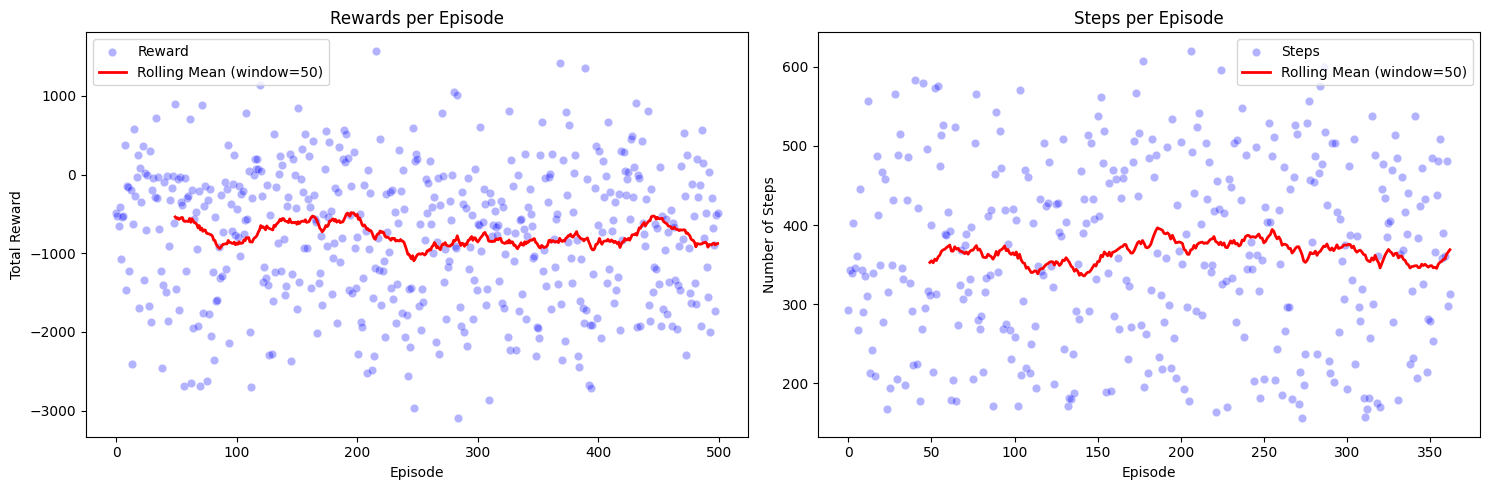

In [41]:
# Training and evaluation using different seeds
td_lambda.Env.set_seed(seed)
td_lambda.set_seed(seed)

# Evaluate the agent in inference mode
all_rewards, all_steps, log_file = td_lambda.evaluate(num_episodes=500)

# Print the results
print(f"Average cumulative rewards for TD-Lambda Agent: {round(np.mean(all_rewards))}")
print(f"Average timesteps to termination for TD-Lambda Agent: {round(np.mean(all_steps))}")

td_lambda.plot_metrics(all_rewards, all_steps, window_size=50)
plt.show()

In [7]:
td_lambda.Env.disable_logging()

### Visualization

In [42]:
json_path = log_file

extract_timesteps_from_json(json_path)
gif_filename = os.path.basename(json_path).replace('.json', '.gif')

gif_filepath = f'./gifs/task2/{gif_filename}'

create_visualization_from_cached_data(gif_filename=gif_filepath, step_interval=1)

Timesteps data from the first line successfully cached, containing 293 timesteps
GIF saved at ./gifs/task2/test_log_tdlambda_20241107_164214.gif


### Hyperparameter Tuning

In [19]:
episodes = 500
trials = 10
on_policy = False
hyperparameter_space = {
    'alpha': [1e-4, 1e-1],           # Learning rate range (log scale)
    'gamma': [0.1, 0.99],            # Discount factor range
    'epsilon_min': [0.01, 0.1],      # Minimum epsilon range
    # 'lambd': [0, 0.9]             # Lambda range for eligibility traces
}
env = CustomTrafficEnvironment(max_time_steps=10000, logging_enabled=False, seed=seed)
td_lambda = TemporalDifference(env)
# Run hyperparameter tuning
best_agent, best_params = td_lambda.hyperparameter_tuning(hyperparameter_space=hyperparameter_space, lambd=0, episodes=episodes, n_trials=trials, on_policy=on_policy)

[I 2024-11-07 16:31:01,629] A new study created in memory with name: no-name-32bb63d4-b5da-4aae-aa69-07dbfd4c3cfa
100%|██████████| 500/500 [10:01<00:00,  1.20s/it]
[I 2024-11-07 16:41:03,221] Trial 0 finished with value: -1359.8480000000004 and parameters: {'alpha': 0.002164759661992705, 'gamma': 0.6532820796839962, 'epsilon_min': 0.09158571579138222}. Best is trial 0 with value: -1359.8480000000004.


Early Termination Count: 181
Trial 0: Average Reward = -1359.85


  8%|▊         | 41/500 [01:02<11:43,  1.53s/it]
[W 2024-11-07 16:42:06,108] Trial 1 failed with parameters: {'alpha': 0.02630562986692924, 'gamma': 0.7169002710655344, 'epsilon_min': 0.04552902579790648} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "c:\Users\danie\OneDrive - Singapore Management University\SMU Singapore\Academics\Aug 2024\CS609_ReinforcementLearning\Project\LaneSwitchRL-Simulation\.venv\Lib\site-packages\optuna\study\_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "c:\Users\danie\OneDrive - Singapore Management University\SMU Singapore\Academics\Aug 2024\CS609_ReinforcementLearning\Project\LaneSwitchRL-Simulation\notebooks\../src\task2_agents.py", line 418, in objective
    rewards, _ = self.train(num_episodes=episodes, on_policy = on_policy)
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\danie\OneDrive - Singa

KeyboardInterrupt: 